# Prototype Drone Classification Model (Resnet)
#### John D. Valencia & Max Blumenfeld - Senior Projects 2024

##### Importing Libraries

First, we'll import all the necessary libraries required for data handling, model building, training, and evaluation.

In [19]:
# Suppress TensorFlow warnings for cleaner output
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import datetime
import logging

# Set logging level to ERROR to minimize warnings
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Verify TensorFlow is using the GPU (Apple Silicon)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


### Importing Libraries

First, we'll import all the necessary libraries required for data handling, model building, training, and evaluation.

In [20]:
# Parameters
DATA_DIR = '/Users/johnvalencia/Senior_Projects/data/hybrid_data_split'  # Update if different
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
MODEL_NAME = 'ResNet50'
CLASS_NAMES = ['not_drone', 'drone']  # Ensure this matches your directory structure

# Verify data directory exists
assert os.path.isdir(DATA_DIR), f"Data directory {DATA_DIR} does not exist."


### Loading and Preprocessing the Data

Load the training, validation, and test datasets using image_dataset_from_directory. We'll also apply caching, shuffling, and prefetching for optimized data pipeline performance.

In [21]:
def load_datasets(data_dir, image_size=(224, 224), batch_size=32):
    """
    Loads training, validation, and test datasets from the specified directory.
    """
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')
    test_dir = os.path.join(data_dir, 'test')
    
    print("Loading training dataset from:", train_dir)
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='binary',
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True,
        seed=123
    )
    
    print("Loading validation dataset from:", val_dir)
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        val_dir,
        labels='inferred',
        label_mode='binary',
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True,
        seed=123
    )
    
    print("Loading test dataset from:", test_dir)
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='binary',
        batch_size=batch_size,
        image_size=image_size,
        shuffle=False
    )
    
    return train_ds, val_ds, test_ds

def configure_datasets(train_ds, val_ds, test_ds, buffer_size=1000, AUTOTUNE=tf.data.AUTOTUNE):
    """
    Configures datasets for performance.
    """
    train_ds = train_ds.cache().shuffle(buffer_size).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
    
    return train_ds, val_ds, test_ds

# Load the datasets
train_ds, val_ds, test_ds = load_datasets(DATA_DIR, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

# **Retrieve class names before configuring the datasets**
class_names = train_ds.class_names
print("Class names:", class_names)

# Configure the datasets for performance
train_ds, val_ds, test_ds = configure_datasets(train_ds, val_ds, test_ds)


Loading training dataset from: /Users/johnvalencia/Senior_Projects/data/hybrid_data_split/train
Found 1444 files belonging to 2 classes.
Loading validation dataset from: /Users/johnvalencia/Senior_Projects/data/hybrid_data_split/val
Found 308 files belonging to 2 classes.
Loading test dataset from: /Users/johnvalencia/Senior_Projects/data/hybrid_data_split/test
Found 219 files belonging to 2 classes.
Class names: ['drone', 'not_drone']


### Building the ResNet50 Model

Construct the ResNet50-based model for binary classification.

In [22]:
def build_resnet_model(input_shape=(224, 224, 3)):
    """
    Builds and compiles a ResNet50-based model for binary classification.
    """
    # Load the ResNet50 model without the top classification layer
    base_model = keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze the base model to prevent its weights from being updated during initial training
    base_model.trainable = False
    
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
    ])
    
    # Input layer
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    
    # Preprocessing for ResNet50
    x = keras.applications.resnet50.preprocess_input(x)
    
    # Pass through the base model
    x = base_model(x, training=False)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dropout for regularization
    x = layers.Dropout(0.4  )(x)
    
    # Output layer for binary classification
    outputs = layers.Dense(1, activation='sigmoid')(x)
   
    # Define the model
    model = keras.Model(inputs, outputs)
    
    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build the ResNet50 model
model = build_resnet_model(input_shape=IMAGE_SIZE + (3,))
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 224, 224,  │          0 │ input_layer_10[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_9          │ (None, 224, 224)  │          0 │ sequential_3[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_10         │ (None, 224, 224)  │          0 │ sequential_3[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_11         │ (None, 224, 224)  │          0 │ sequential_3[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_3 (Stack)     │ (None, 224, 224,  │          0 │ get_item_9[0][0], │
│                     │ 3)                │            │ get_item_10[0][0… │
│                     │                   │            │ get_item_11[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 224, 224,  │          0 │ stack_3[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_3[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      2,049 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Define Training Callbacks

In [23]:
# Set up callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='../models/resnet50_best_model.keras', 
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    )
]


### Training the Model

Train the ResNet50 model using the training dataset and validate on the validation dataset.

In [24]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 834ms/step - accuracy: 0.7136 - loss: 0.5625 - val_accuracy: 0.9773 - val_loss: 0.1149
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 802ms/step - accuracy: 0.9386 - loss: 0.1898 - val_accuracy: 0.9805 - val_loss: 0.0785
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 806ms/step - accuracy: 0.9493 - loss: 0.1373 - val_accuracy: 0.9805 - val_loss: 0.0626
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 781ms/step - accuracy: 0.9704 - loss: 0.0963 - val_accuracy: 0.9805 - val_loss: 0.0673
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 779ms/step - accuracy: 0.9642 - loss: 0.0989 - val_accuracy: 0.9805 - val_loss: 0.0576
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 785ms/step - accuracy: 0.9742 - loss: 0.0742 - val_accuracy: 0.9838 - val_loss: 0.0433
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 777ms/step - accuracy: 0.9742 - loss: 0.0733 - val_accuracy: 0.9805 - val_loss: 0.0462
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 783ms/step - accuracy: 0.9693 - loss: 0.0870 - val_accu

### Visualizing Training History

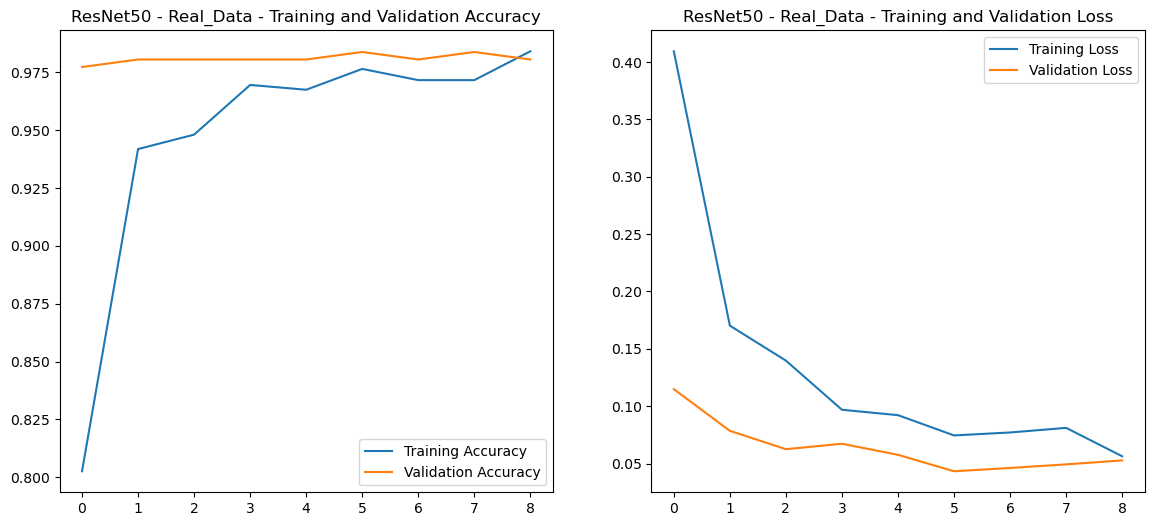

In [25]:
def plot_training_history(history, model_name, dataset_type):
    """
    Plots training and validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(14, 6))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - {dataset_type} - Training and Validation Accuracy')
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - {dataset_type} - Training and Validation Loss')
    
    plt.show()

# Plot training history
plot_training_history(history, MODEL_NAME, 'Real_Data')


### Evaluating the Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Classification Report:
              precision    recall  f1-score   support

       drone       0.98      0.97      0.98        63
   not_drone       0.99      0.99      0.99       156

    accuracy                           0.99       219
   macro avg       0.99      0.98      0.98       219
weighted avg       0.99      0.99      0.99       219

Confusion Matrix:
[[ 61   2]
 [  1 155]]


2024-11-11 11:24:39.211422: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


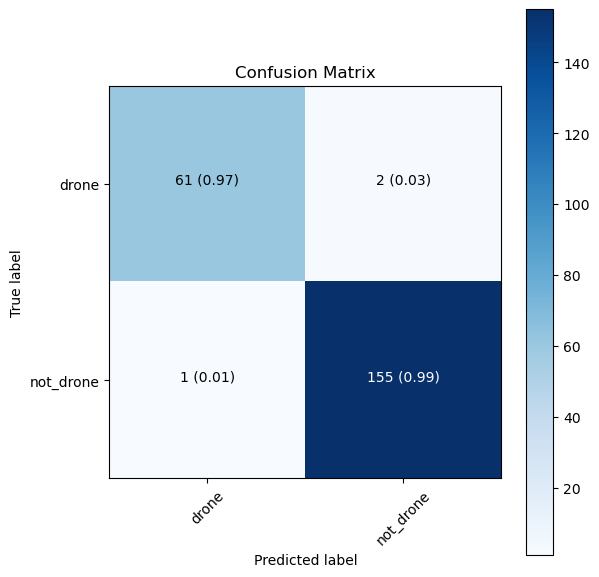

In [26]:
def evaluate_model(model, test_ds, class_names):
    """
    Evaluates the model on the test dataset and prints classification metrics.
    """
    # Get predictions and true labels
    y_true = []
    y_pred = []
    
    for images, labels in test_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend((preds > 0.5).astype(int).flatten())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]} ({cm_normalized[i, j]:.2f})",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Evaluate the model
evaluate_model(model, test_ds, class_names)


### Saving the Model

In [27]:
# Save the model in TensorFlow's SavedModel format
model.save('../models/resnet50_model_2.keras')
print("Model training and evaluation completed. Model saved to 'models/resnet50_model_2'.")

Model training and evaluation completed. Model saved to 'models/resnet50_model_2'.
